### Self-Driving Car Engineer Nanodegree


# Project: **Finding Lane Lines on the Road** 
---
Jussi Wright
31.5.2017

#### Goal of the project: 
Detect the line segments in the image, then average/extrapolate them and draw them onto the image for display.  

I develop the pipeline on a series of individual images, and later apply the result to a video stream. 

The writeup is completed in a separate file.

---

#### My pipeline consists of next steps::

- Import packages and read in an images
- Image processing (color selection, grayscaling, Gaussian smoothing) 
- Selecting regions to search for lane lines (region of interest selection)
- Edge detection (Canny Edge, Hough Tranform, separating line segments)
- Apply lines to the original image

The purpose of the pipeline is to compose several different operations together, apply them to an image, and produce an annotated image that shows where a lane on a road would be.


## Import Packages

In [118]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

# to show interactive result
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


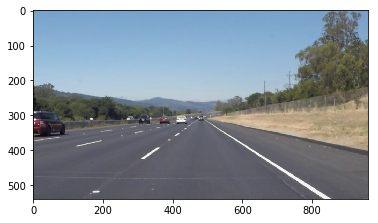

In [119]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Image processing

In [120]:
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

IndentationError: expected an indented block (<ipython-input-120-c83d860f8d98>, line 6)

## Region of interest
Applies an image mask.

In [121]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Draw Lines 1
Separating line sehments by their slope.


In [149]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=13):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x_size = img.shape[1]
    y_size = img.shape[0]
    
    lines_slope_intercept = np.zeros(shape=(len(lines),2))
    
    for index,line in enumerate(lines):        
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - x1 * slope
            lines_slope_intercept[index]=[slope,intercept]
            
    max_slope_line = lines_slope_intercept[lines_slope_intercept.argmax(axis=0)[0]]
    min_slope_line = lines_slope_intercept[lines_slope_intercept.argmin(axis=0)[0]]
    left_slopes = []
    left_intercepts = []
    right_slopes = []
    right_intercepts = []

    
    # slopes and intercepts lines
    for line in lines_slope_intercept:
        if abs(line[0] - max_slope_line[0]) < 0.15 and abs(line[1] - max_slope_line[1]) < (0.15 * x_size):
            left_slopes.append(line[0])
            left_intercepts.append(line[1])
        elif abs(line[0] - min_slope_line[0]) < 0.15 and abs(line[1] - min_slope_line[1]) < (0.15 * x_size):
            right_slopes.append(line[0])
            right_intercepts.append(line[1])
   
    # left and right lines are averages of these slopes and intercepts, extrapolate lines to edges and center
    new_lines = np.zeros(shape=(1,2,4), dtype=np.int32)
    
    if len(left_slopes) > 0:
        left_line = [sum(left_slopes)/len(left_slopes),sum(left_intercepts)/len(left_intercepts)]
        left_bottom_x = (y_size - left_line[1])/left_line[0]
        left_top_x = (y_size*.575 - left_line[1])/left_line[0]
        if (left_bottom_x >= 0):
            new_lines[0][0] =[left_bottom_x,y_size,left_top_x,y_size*.575]
            
    if len(right_slopes) > 0:
        right_line = [sum(right_slopes)/len(right_slopes),sum(right_intercepts)/len(right_intercepts)]
        right_bottom_x = (y_size - right_line[1])/right_line[0]
        right_top_x = (y_size*.575 - right_line[1])/right_line[0]
        if (right_bottom_x <= x_size):
            new_lines[0][1]=[right_bottom_x,y_size,right_top_x,y_size*.575]
    
    
    for line in new_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)   

## Draw lines 2
Hough lines and weighted

In [123]:

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


### Prosess Image


In [141]:
def process_image(image, mode=2):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
     
        
    # make grey scale image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5 # must be odd
    blur_gray = gaussian_blur(gray, kernel_size)


    # Define parameters for Canny and apply
    # low to high ratio must be 1:2 or 1:3
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    
    # Defining a four sided polygon to mask
    imshape=image.shape
    
    vertices = np.array([[(160,imshape[0]),(440, 300), (500, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
 

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2               # distance resolution in pixels of the Hough grid (2-3 ok)
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 50        # minimum number of votes (intersections in Hough grid cell)(20-70 ok)
    min_line_length = 40  # minimum number of pixels making up a line (30-50 ok)
    max_line_gap = 50     # maximum gap in pixels between connectable line segments (30-100 ok)
    
    
    if(mode==2) :
        hough_line_image = hough_lines2(masked_edges, rho, theta, threshold,min_line_length, max_line_gap)
    else :
        hough_line_image = hough_lines(masked_edges, rho, theta, threshold,min_line_length, max_line_gap)


    color_hough = np.dstack((hough_line_image, np.copy(hough_line_image)*0, np.copy(hough_line_image)*0)) 

    
    color_hough[:,:,1] = 0
    
 
    
    result=weighted_img( color_hough, image)
    
    # Create a "color" binary image to combine with line image
    return result

## Image test 1
Splitted line


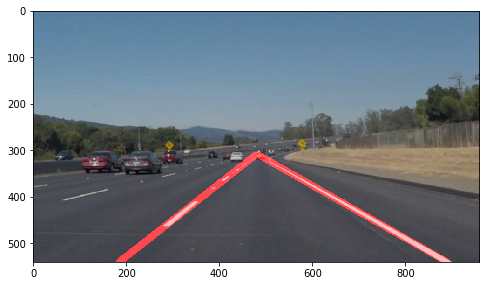

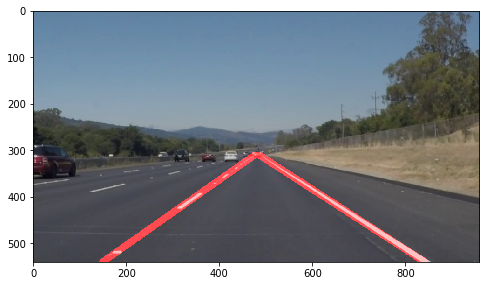

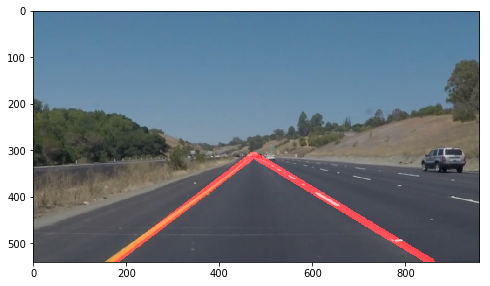

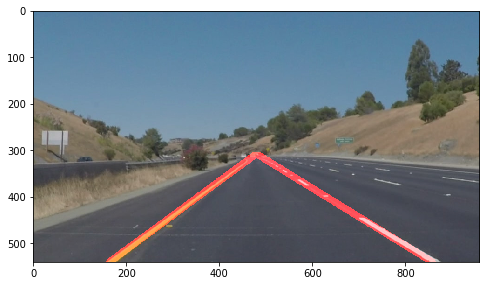

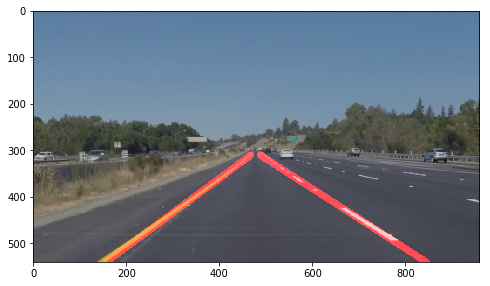

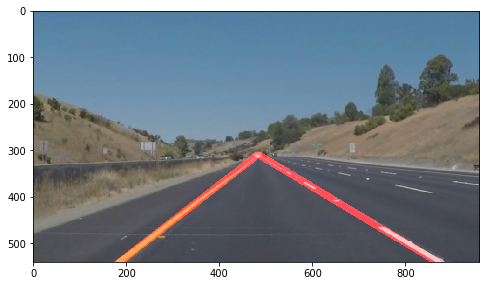

In [157]:
image_files = os.listdir("test_images/")

i=0
for image_file in image_files:
    
    image = mpimg.imread("test_images/"+image_file) # image read

    laneline_image = process_image(image,1)
    i=i+1
    plt.figure(figsize=(8,10)) 
    plt.imshow(laneline_image) # show image

## Image test 2
Conected line

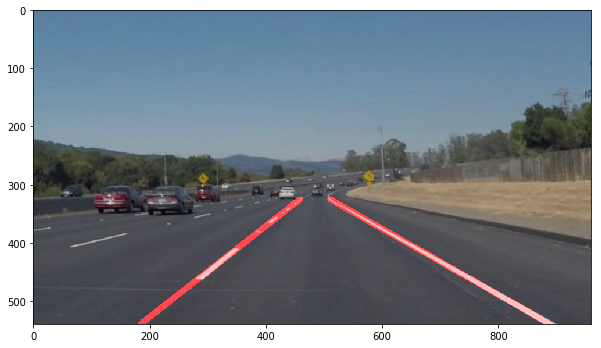

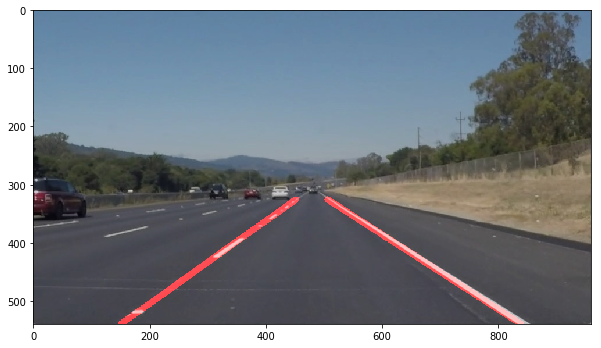

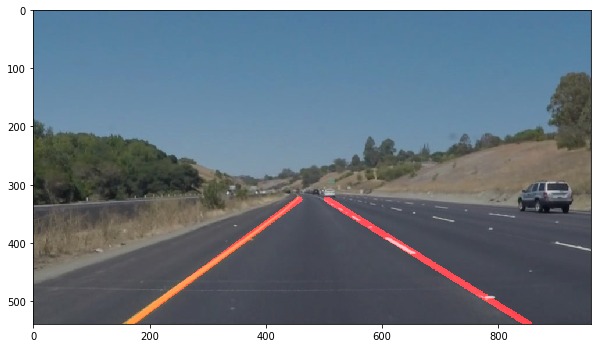

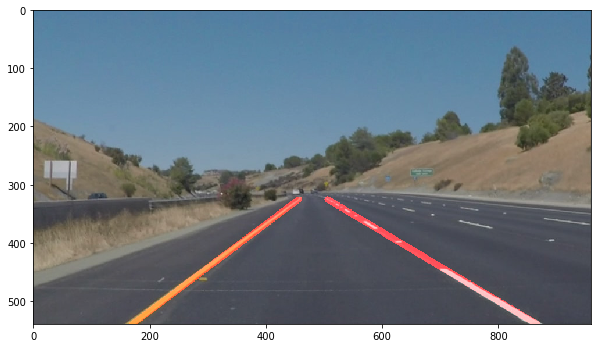

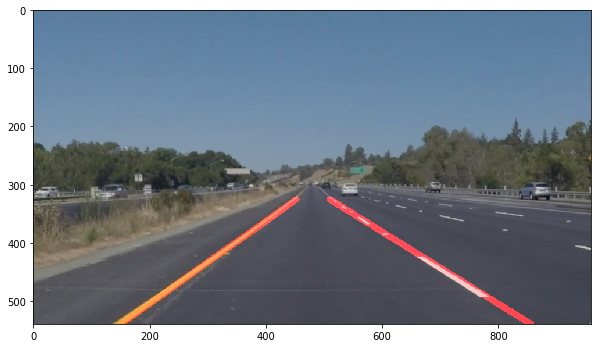

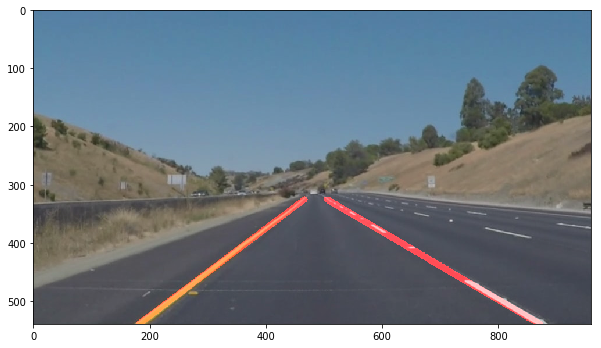

In [143]:
image_files = os.listdir("test_images/")

i=0
for image_file in image_files:
    
    image = mpimg.imread("test_images/"+image_file) # image read
    #original_img = np.copy(image)*0 # make original image 
    laneline_image = process_image(image)
    i=i+1
    plt.figure(figsize=(10,12))
    plt.imshow(laneline_image)

### Video Testing 1 : solidWhiteRight.mp4
solid white lane on the right

In [74]:
#video version
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

#Play the video inline, or if you prefer find the video in your filesystem 
#(should be in the same directory) and play it in your video player of choice.
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


 99%|█████████▉| 125/126 [00:02<00:00, 46.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.54 s, sys: 526 ms, total: 2.06 s
Wall time: 3.31 s


### Video Testing 2 : solidWhiteRight.mp4
the solid yellow lane on the left

In [75]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.43 s, sys: 2.97 s, total: 11.4 s
Wall time: 17.6 s


### Optional Challenge : challenge.mp4



In [144]:
#main pipeline for challenge.mp4

def process_image(image, mode=2):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
     
    # make grey scale image
    gray = grayscale(image)
    
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5 # must be odd
    blur_gray = gaussian_blur(gray, kernel_size)


    # Define parameters for Canny and apply
    # low to high ratio must be 1:2 or 1:3
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    
    # Defining a four sided polygon to mask
    imshape=image.shape
    
    vertices = np.array([[(160,imshape[0]),(440, 320), (500, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
 

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2               # distance resolution in pixels of the Hough grid (2-3 ok)
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 50        # minimum number of votes (intersections in Hough grid cell)(20-70 ok)
    min_line_length = 40  # minimum number of pixels making up a line (30-50 ok)
    max_line_gap = 70     # maximum gap in pixels between connectable line segments (30-100 ok)
    
    
    if(mode==2) :
        hough_line_image = hough_lines2(masked_edges, rho, theta, threshold,min_line_length, max_line_gap)
    else :
        hough_line_image = hough_lines(masked_edges, rho, theta, threshold,min_line_length, max_line_gap)


    color_hough = np.dstack((hough_line_image, np.copy(hough_line_image)*0, np.copy(hough_line_image)*0)) 

    
    color_hough[:,:,1] = 0
    
 
    
    result=weighted_img( color_hough, image)
    
    # Create a "color" binary image to combine with line image
    return result

In [152]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 20.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.83 s, sys: 2.15 s, total: 7.99 s
Wall time: 14.5 s


---
## Reflections


### Shortcomings

- Sensitive to colour contrast on the road (bridge)
- Sensitive to lane location


### Improvements
- Back probation, use info from past frames
- More automatic calculated parts like region and color mask range 
